In [1]:
# Assignment 9
# Development of a tracking filter of a moving object when measurements and motion models are in different coordinate systems.
# Team 2:
#     Ekaterina Karmanova
#     Timur Chikichev
#     Iaroslav Okunevich
#     Nikita Mikhailovskiy
#
# Skoltech, 15.10.2019

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
#1
#Generate trajectory in cartesian coordinates.
def MatrixX(size,t,x0=13500/(np.sqrt(2)),y0=13500/(np.sqrt(2))):
        trajectory=np.zeros([4,size])        
        trajectory[0,0]=x0
        trajectory[1,0]=-50
        trajectory[2,0]=y0
        trajectory[3,0]=-45
        for i in range(1,size):
            trajectory[0,i]=trajectory[0,i-1]+trajectory[1,i-1]*t
            trajectory[1,i]=trajectory[1,i-1]
            trajectory[2,i]=trajectory[2,i-1]+trajectory[3,i-1]*t
            trajectory[3,i]=trajectory[3,i-1]
        return trajectory
    
trajectoryCartesian=MatrixX(26,2)

In [4]:
#2
#Trajectory in cartesian coordinates is transformed to trajectory in polar coordinates.
def PolarTrajectory(matrixCartesian):
        trajectoryPolar=np.zeros([2,matrixCartesian.shape[1]]) 
        for i in range(0,matrixCartesian.shape[1]):
            trajectoryPolar[0,i]=np.sqrt(matrixCartesian[0,i]**2+matrixCartesian[2,i]**2)
            trajectoryPolar[1,i]=np.arctan(matrixCartesian[0,i]/matrixCartesian[2,i])
        return trajectoryPolar
trajectoryPolar=PolarTrajectory(trajectoryCartesian)

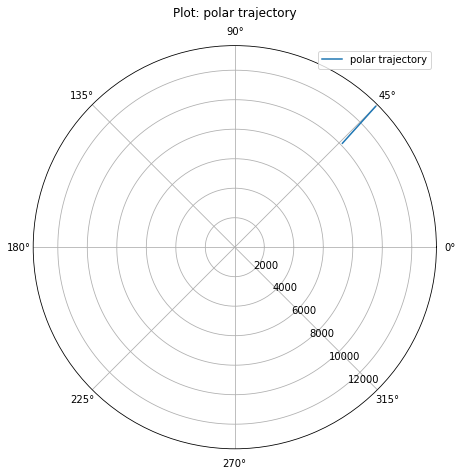

In [5]:
#Plot of trajectory in polar coordinate system.
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
ax.plot(trajectoryPolar[1],trajectoryPolar[0],label='polar trajectory')
ax.set_title("Plot: polar trajectory", va='bottom')
ax.set_rlabel_position(-50.5)
ax.legend()
plt.show()  

In [6]:
#3
#Create measurements for polar trajectory.
def Measurements(trajectoryPolar,nyD,nyB):
        z=np.zeros([2,trajectoryPolar.shape[1]])
        for i in range(0, trajectoryPolar.shape[1]):
            z[0,i]=trajectoryPolar[0,i]+nyD[i]
            z[1,i]=trajectoryPolar[1,i]+nyB[i]
        return z
#Array of sigmaD and sigmaB 
sigmasTrue=[20,0.02]
nyD= np.random.normal(0, sigmasTrue[0], 26)
nyB= np.random.normal(0, sigmasTrue[1], 26)
z=Measurements(trajectoryPolar,nyD,nyB)

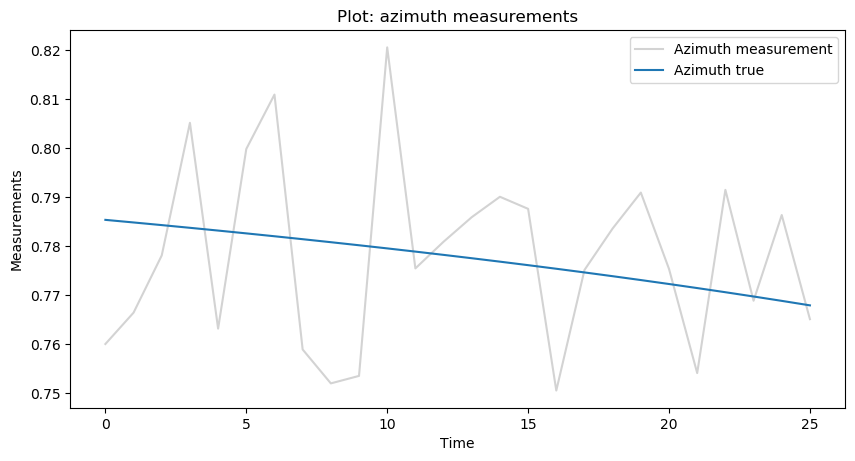

In [7]:
#Plot azimuth measurements.
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: azimuth measurements')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z[1],label='Azimuth measurement',color='lightgrey')
plt.plot(trajectoryPolar[1],label='Azimuth true')
plt.legend()
plt.show()  

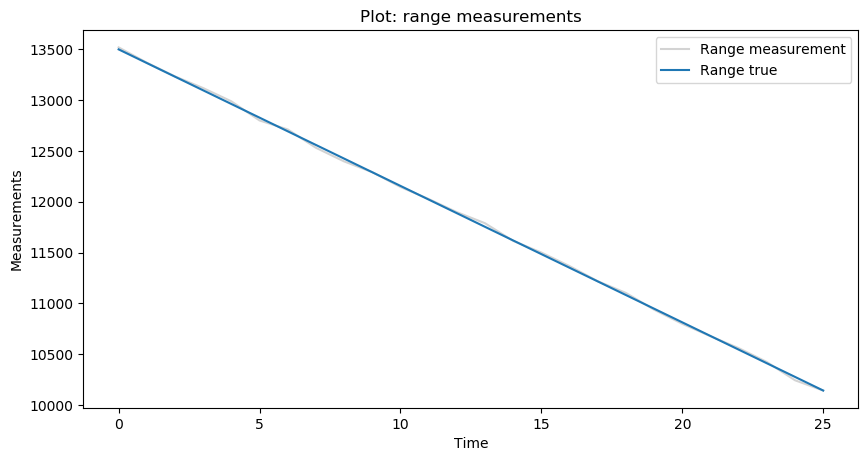

In [8]:
#Plot range measurements.
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: range measurements')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z[0],label='Range measurement',color='lightgrey')
plt.plot(trajectoryPolar[0],label='Range true')
plt.legend()
plt.show()  

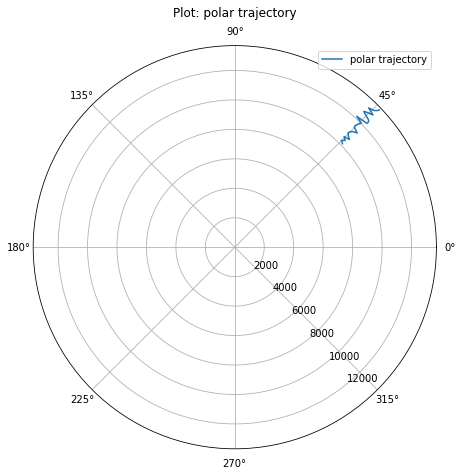

In [9]:
#Plot of measurements trajectory in polar coordinate system.
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
ax.plot(z[1],z[0],label='polar trajectory')
ax.set_title("Plot: polar trajectory", va='bottom')
ax.set_rlabel_position(-50.5)
ax.legend()
plt.show()  

In [10]:
#4,5
#Measurements trajectory in polar system is transformed to measurements trajectory in cartesian coordinates.
#Pseudo-measurements of coordinate x and y.
def MeasurementsXY(trajectoryPolarMeasurements):
        measurementsXY=np.zeros([2,trajectoryPolarMeasurements.shape[1]])
        for i in range(0, trajectoryPolarMeasurements.shape[1]):
            measurementsXY[0,i]=trajectoryPolarMeasurements[0,i]*np.sin(trajectoryPolarMeasurements[1,i])
            measurementsXY[1,i]=trajectoryPolarMeasurements[0,i]*np.cos(trajectoryPolarMeasurements[1,i])
        return measurementsXY
measurementsXY=MeasurementsXY(z)

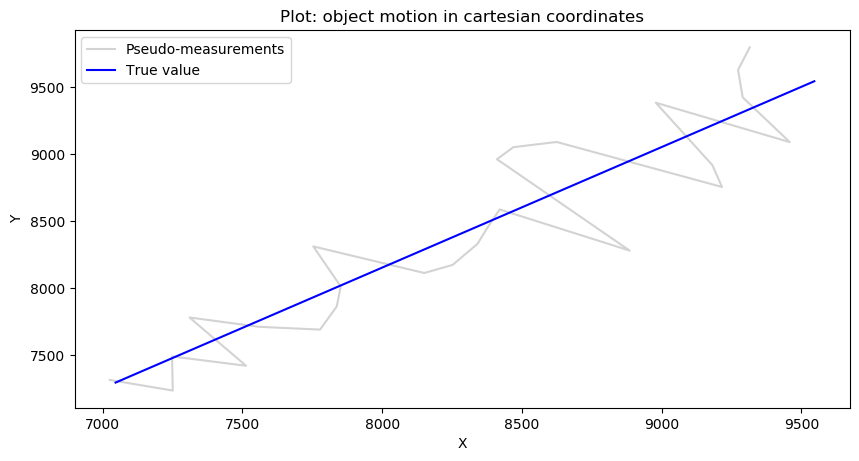

In [62]:
#Plot of true trajectory and pseudo-measurements in cartesuan coordinates.
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: object motion in cartesian coordinates')
plt.ylabel('Y')
plt.xlabel('X')
plt.plot(measurementsXY[0],measurementsXY[1],label='Pseudo-measurements',color='lightgrey')
plt.plot(trajectoryCartesian[0],trajectoryCartesian[2],label='True value',color='blue')
plt.legend()
plt.show()  

In [12]:
#6
#Initial conditions for Kalman filter algorithm
#Initial filtered estimate
x00=np.matrix([[40000],
              [-20],
              [40000],
              [-20]])
#Initial filtration error covariance matrix
p00=np.eye(4)
p00*=10**10

In [13]:
#7
#Create the transition matrix Φ
def SetupFi(t):
    fi=np.eye(4)
    fi[0,1]=t
    fi[2,3]=t
    return fi
FI=SetupFi(2)

#Create the observation matrix 𝐻
H=np.matrix([[1,0,0,0],
             [0,0,1,0]])

In [63]:
#8
#Create the measurement error covariance matrix 𝑅
def FindR(sigmasDB,measD,measB):
    elem00=(np.sin(measB)**2)*(sigmasDB[0]**2)+(measD**2)*(np.cos(measB)**2)*(sigmasDB[1])**2
    elem01=np.sin(measB)*np.cos(measB)*(sigmasDB[0]**2-(measD*sigmasDB[1])**2)
    elem10=elem01
    elem11=(np.cos(measB)**2)*(sigmasDB[0]**2)+(measD**2)*(np.sin(measB)**2)*(sigmasDB[1])**2
    return np.matrix([[elem00,elem01],
                      [elem10,elem11]])
R=FindR(sigmasTrue,z[0,0],z[1,0])

In [15]:
#Initialization function for Kalman filter
#Prediction estimate
def XPrediction(fi,x00):
    return np.dot(fi,x00)
#Prediction error
def PPrediction(p00,fi,q):
    return np.dot(np.dot(fi,p00),fi.transpose())+q
#Filter gain
def FindKI(pIIMinus1,h,r):
    onePart=np.dot(pIIMinus1,h.transpose())
    secondpart=np.dot(np.dot(h,pIIMinus1),h.transpose())+r
    return np.dot(onePart,secondpart.I)
#Filtration error
def FindPII(pIIMinus1,k,h):
    return np.dot(np.eye(4)-np.dot(k,h),pIIMinus1)
#Improved estimate
def FindXI(xI,k,zI,h):
    return xI+np.dot(k,(zI-h*xI))

In [2]:
#9
#Filter Calman. Return tracjectKalman -  [0] - X
                                        #[1] - Vx
                                        #[2] - Y
                                        #[3] - Vy
                #arrayXExtrapolation -   [0] - D extrapolation
                                        #[1] - Azimuth extrapolation
def Kalman(z,h,fi,q,pFiltration,x00,sigmasDB):
    arrayXExtrapolation=np.zeros((2,z.shape[1]))
    tracjectKalman=np.zeros((4,z.shape[1]))
    tracjectKalman[0,0]=x00[0,0]
    tracjectKalman[1,0]=x00[1] 
    tracjectKalman[2,0]=x00[2]
    tracjectKalman[3,0]=x00[3]
    x0=x00
    for i in range(1,z.shape[1]):         
        xPred=XPrediction(fi,x0)
        pPrediction=PPrediction(pFiltration, fi, q)
        r=FindR(sigmasDB,z[0,i],z[1,i])
        k=FindKI(pPrediction,h,r)
        zCartesian=np.matrix([[z[0,i]*np.sin(z[1,i])],
                              [z[0,i]*np.cos(z[1,i])]])
        xii=FindXI(xPred,k,zCartesian,h)
        x0=xii
        pFiltration=FindPII(pPrediction,k,h) 
        
        tracjectKalman[0,i]=xii[0]
        tracjectKalman[1,i]=xii[1]
        tracjectKalman[2,i]=xii[2]
        tracjectKalman[3,i]=xii[3]
        
        arrayXExtrapolation[0,i]=np.sqrt(xPred[0]**2+xPred[2]**2)
        arrayXExtrapolation[1,i]=np.arctan(xPred[0]/xPred[2])
        
    return tracjectKalman, arrayXExtrapolation
tracjectKalman, arrayXExtrapolation=Kalman(z,H,FI,0,p00,x00,sigmasTrue)

NameError: name 'z' is not defined

NameError: name 'tracjectKalman' is not defined

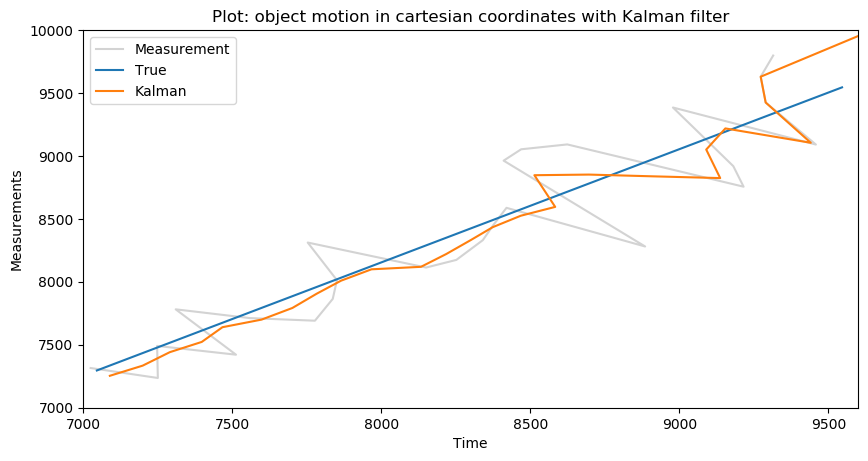

In [64]:
#Plot of true, filter trajectories and pseudo-measurements in cartesuan coordinates.
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: object motion in cartesian coordinates with Kalman filter')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(measurementsXY[0],measurementsXY[1],label='Measurement',color='lightgray')
plt.plot(trajectoryCartesian[0],trajectoryCartesian[2],label='True')
plt.plot(tracjectKalman[0],tracjectKalman[2],label='Kalman')
plt.xlim(7000,9600)
plt.ylim(7000,10000)
plt.legend()
plt.show()  

In [65]:
#10
#Errors of extrapolation and filtration estimates
def FinalError(H,FI,runs,pFiltration,x00,sigmasTrue,step=7):
    finalError=np.zeros((2,26))
    extropolationError=np.zeros((2,26))
    for i in range(runs):
        
        trajectoryCartesian=MatrixX(26,2)
        trajectoryPolar=PolarTrajectory(trajectoryCartesian)
        nyD= np.random.normal(0, sigmasTrue[0], 26)
        nyB= np.random.normal(0, sigmasTrue[1], 26)
        z=Measurements(trajectoryPolar,nyD,nyB)
        
        tracjectKalman, arrayXExtrapolation=Kalman(z,H,FI,0,pFiltration,x00,sigmasTrue)
                
        for j in range(trajectoryCartesian.shape[1]):
            distance=np.sqrt(tracjectKalman[0,j]**2+tracjectKalman[2,j]**2)
            azimuth=np.arctan(tracjectKalman[0,j]/tracjectKalman[2,j])
            finalError[0,j]+=(trajectoryPolar[0,j]-distance)**2
            finalError[1,j]+=(trajectoryPolar[1,j]-azimuth)**2
            extropolationError[0,j]+=(trajectoryPolar[0,j]-arrayXExtrapolation[0,j])**2
            extropolationError[1,j]+=(trajectoryPolar[1,j]-arrayXExtrapolation[1,j])**2
            
    for i in range(trajectoryCartesian.shape[1]):
        finalError[0,i]=np.sqrt(finalError[0,i]/(runs-1)) 
        finalError[1,i]=np.sqrt(finalError[1,i]/(runs-1)) 
        extropolationError[0,i]=np.sqrt(extropolationError[0,i]/(runs-1)) 
        extropolationError[1,i]=np.sqrt(extropolationError[1,i]/(runs-1))
        
    return finalError, extropolationError

In [66]:
#Calculating true errors of estimation for x0,y0=13500/sqrt(2), sigma=20,0.02
finalError, extropolationError=FinalError(H,FI,500,p00,x00,sigmasTrue)

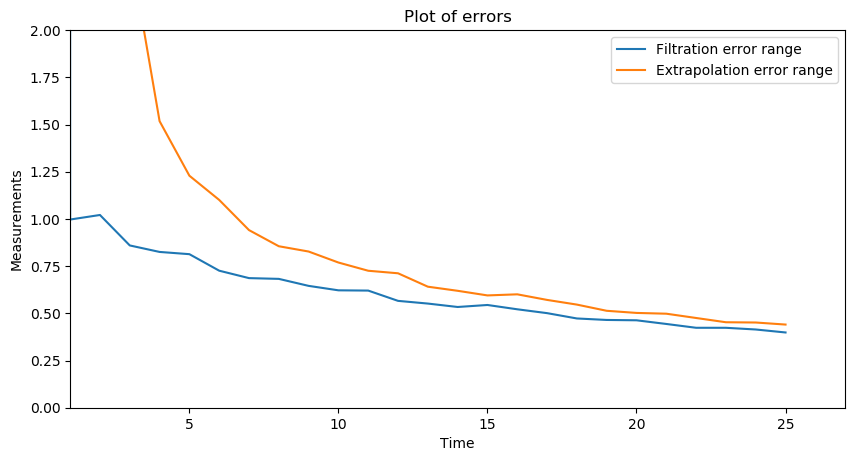

In [21]:
#Plot of relative errors range for x0,y0=13500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of errors')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(finalError[0]/20,label='Filtration error range')
plt.plot(extropolationError[0]/20,label='Extrapolation error range')
plt.xlim(1,27)
plt.ylim(0,2)
plt.legend()
plt.show()  

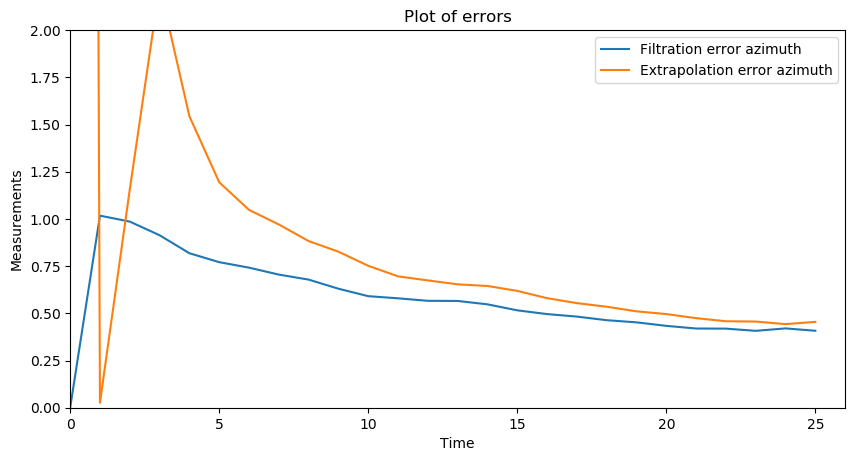

In [22]:
#Plot of relative errors azimuth for x0,y0=13500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of errors')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(finalError[1]/0.02,label='Filtration error azimuth')
plt.plot(extropolationError[1]/0.02,label='Extrapolation error azimuth')
plt.xlim(0,26)
plt.ylim(0,2)
plt.legend()
plt.show()  

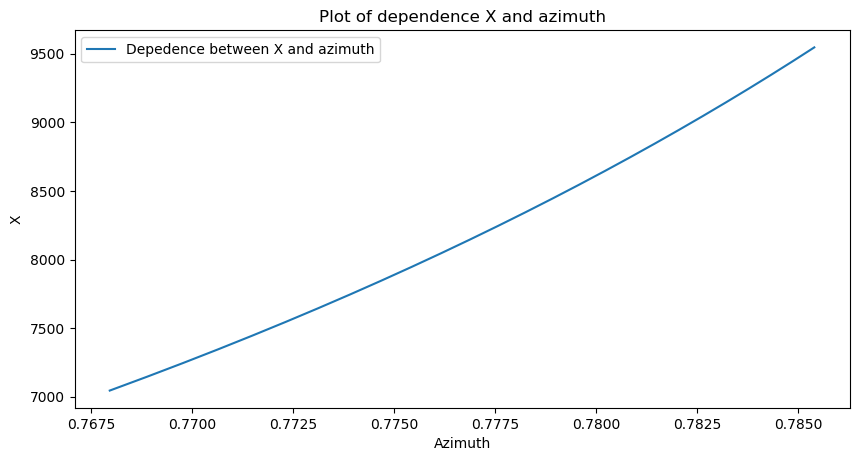

In [67]:
#11
#Plot of dependence X and azimuth for x0,y0=13500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of dependence X and azimuth')
plt.ylabel('X')
plt.xlabel('Azimuth')
plt.plot(trajectoryPolar[1],trajectoryCartesian[0],label='Depedence between X and azimuth')
plt.legend()
plt.show()  

In [24]:
#12
#Filter Calman. Return arrayRCondition -  [0] - Condition number R
                              #arrayK -   [0] - filter gain K
def KalmanConditionNumber(z,h,fi,q,pFiltration,x00,sigmasDB):
    arrayK=np.zeros(z.shape[1])
    arrayRCondition=np.zeros(z.shape[1])
    tracjectKalman=np.zeros((4,z.shape[1]))
    tracjectKalman[0,0]=x00[0,0]
    tracjectKalman[1,0]=x00[1] 
    tracjectKalman[2,0]=x00[2]
    tracjectKalman[3,0]=x00[3]
    x0=x00
    for i in range(1,z.shape[1]):         
        xPred=XPrediction(fi,x0)
        pPrediction=PPrediction(pFiltration, fi, q)
        r=FindR(sigmasDB,z[0,i],z[1,i])
        arrayRCondition[i]=np.linalg.cond(r)
        k=FindKI(pPrediction,h,r)
        arrayK[i]=k[0,0]
        zCartesian=np.matrix([[z[0,i]*np.sin(z[1,i])],
                              [z[0,i]*np.cos(z[1,i])]])
        xii=FindXI(xPred,k,zCartesian,h)
        x0=xii
        pFiltration=FindPII(pPrediction,k,h)         
            
        tracjectKalman[0,i]=xii[0]
        tracjectKalman[1,i]=xii[1]
        tracjectKalman[2,i]=xii[2]
        tracjectKalman[3,i]=xii[3]
    arrayRCondition=np.delete(arrayRCondition, 0)
    arrayK=np.delete(arrayK, 0)
    return arrayRCondition, arrayK
#Calculating condition number of covariance matrix R for x0,y0=13500/sqrt(2), sigma=20,0.02
arrayRCondition, arrayK=KalmanConditionNumber(z,H,FI,0,p00,x00,sigmasTrue)

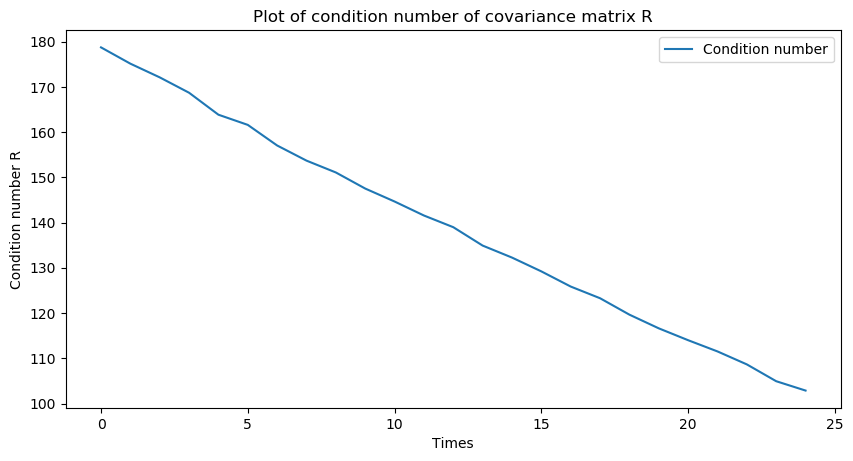

In [54]:
#Plot of condition number of covariance matrix R for x0,y0=13500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of condition number of covariance matrix R')
plt.ylabel('Condition number R')
plt.xlabel('Times')
plt.plot(arrayRCondition,label='Condition number')
plt.legend()
plt.show()  

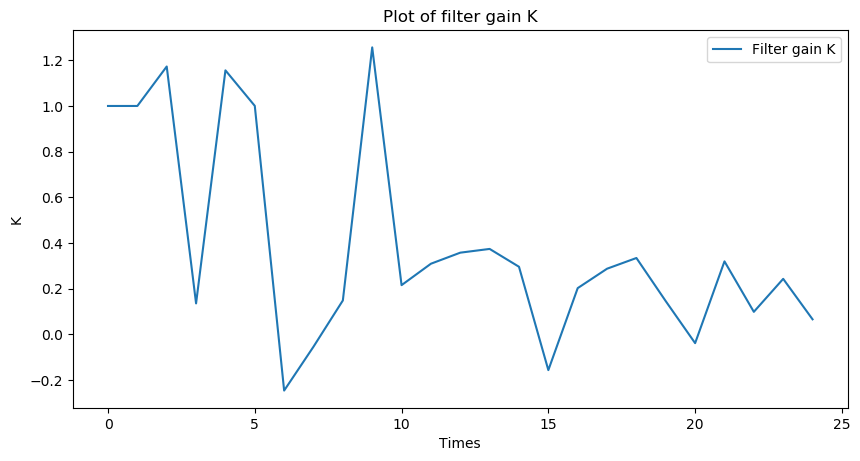

In [26]:
#13
#Plot of filter gain K
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of filter gain K')
plt.ylabel('K')
plt.xlabel('Times')
plt.plot(arrayK,label='Filter gain K')
plt.legend()
plt.show()  

In [27]:
#14
#Errors of extrapolation and filtration estimates for x0,y0=3500/sqrt(2), sigma=20,0.02
def FinalError14(H,FI,runs,pFiltration,x00,sigmasTrue):
    error=0
    finalError=np.zeros((2,26))
    extropolationError=np.zeros((2,26))
    for i in range(runs):
        
        trajectoryCartesian=MatrixX(26,2,x0=3500/(np.sqrt(2)),y0=3500/(np.sqrt(2)))
        trajectoryPolar=PolarTrajectory(trajectoryCartesian)
        nyD= np.random.normal(0, 20, 26)
        nyB= np.random.normal(0, 0.02, 26)
        z=Measurements(trajectoryPolar,nyD,nyB)
        
        tracjectKalman, arrayXExtrapolation=Kalman(z,H,FI,0,pFiltration,x00,sigmasTrue)
                
        for j in range(trajectoryCartesian.shape[1]):
            distance=np.sqrt(tracjectKalman[0,j]**2+tracjectKalman[2,j]**2)
            azimuth=np.arctan(tracjectKalman[0,j]/tracjectKalman[2,j])
            finalError[0,j]+=(trajectoryPolar[0,j]-distance)**2
            finalError[1,j]+=(trajectoryPolar[1,j]-azimuth)**2            
            extropolationError[0,j]+=(trajectoryPolar[0,j]-arrayXExtrapolation[0,j])**2
            extropolationError[1,j]+=(trajectoryPolar[1,j]-arrayXExtrapolation[1,j])**2            
            
    finalError=np.sqrt(finalError/(runs-1))
    extropolationError=np.sqrt(extropolationError/(runs-1))
    return finalError, extropolationError

In [28]:
#Generate trajectory with x0,y0=3500/sqrt(2), sigma=20,0.02
trajectoryCartesian14=MatrixX(26,2,x0=3500/(np.sqrt(2)),y0=3500/(np.sqrt(2)))
trajectoryPolar14=PolarTrajectory(trajectoryCartesian14)
z14=Measurements(trajectoryPolar14,nyD,nyB)

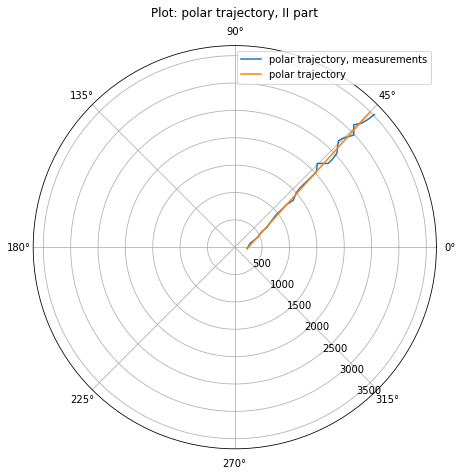

In [29]:
#Polar plot for x0,y0=3500/sqrt(2), sigma=20,0.02
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
ax.plot(z14[1],z14[0],label='polar trajectory, measurements')
ax.plot(trajectoryPolar14[1],trajectoryPolar14[0],label='polar trajectory')
ax.set_title("Plot: polar trajectory, II part", va='bottom')
ax.set_rlabel_position(-50.5)
ax.legend()
plt.show()  

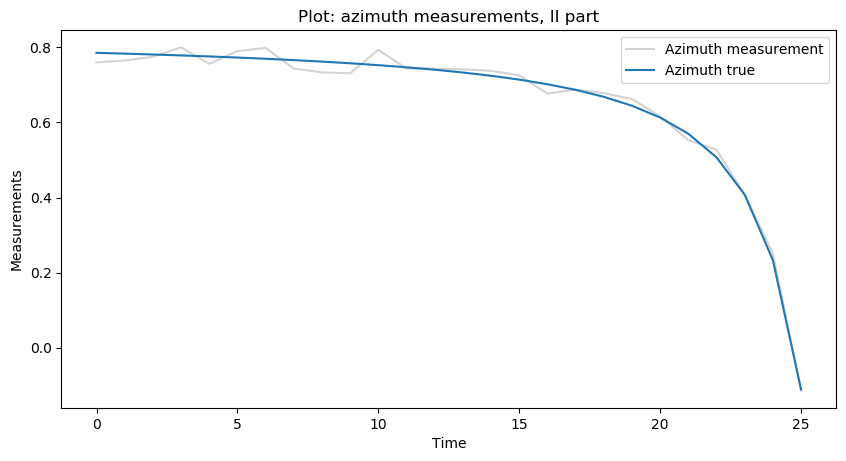

In [30]:
#Plot azimuth measurements for x0,y0=3500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: azimuth measurements, II part')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z14[1],label='Azimuth measurement',color='lightgrey')
plt.plot(trajectoryPolar14[1],label='Azimuth true')
plt.legend()
plt.show()  

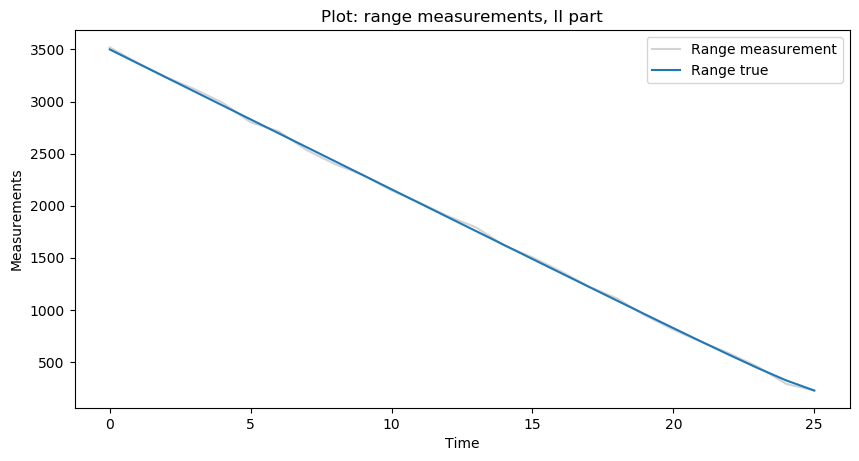

In [31]:
#Plot range measurements for x0,y0=3500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: range measurements, II part')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z14[0],label='Range measurement',color='lightgrey')
plt.plot(trajectoryPolar14[0],label='Range true')
plt.legend()
plt.show()  

In [32]:
#15
#Calculating true errors of estimation for x0,y0=3500/sqrt(2), sigma=20,0.02
finalError14, extropolationError14=FinalError14(H,FI,500,p00,x00,sigmasTrue)

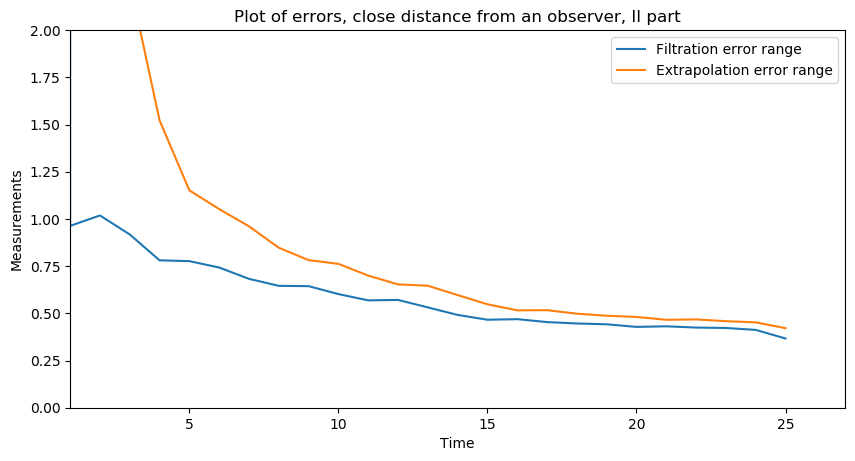

In [33]:
#Plot of relative errors range for x0,y0=3500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of errors, close distance from an observer, II part')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(finalError14[0]/20,label='Filtration error range')
plt.plot(extropolationError14[0]/20,label='Extrapolation error range')
plt.xlim(1,27)
plt.ylim(0,2)
plt.legend()
plt.show()  

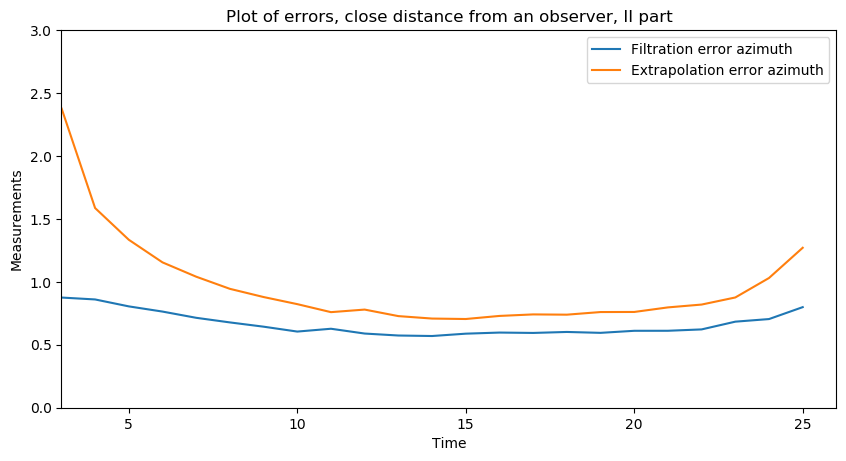

In [50]:
#Plot of relative errors azimuth for x0,y0=3500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of errors, close distance from an observer, II part')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(finalError14[1]/0.02,label='Filtration error azimuth')
plt.plot(extropolationError14[1]/0.02,label='Extrapolation error azimuth')
plt.ylim(0,3)
plt.xlim(3,26)
plt.legend()
plt.show()  

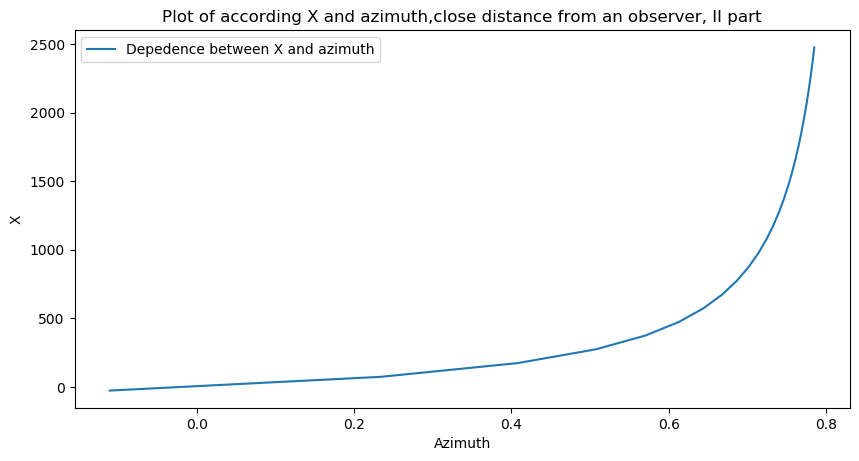

In [55]:
#16
#Plot of dependence X and azimuth for x0,y0=3500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of according X and azimuth,close distance from an observer, II part')
plt.ylabel('X')
plt.xlabel('Azimuth')
plt.plot(trajectoryPolar14[1],trajectoryCartesian14[0],label='Depedence between X and azimuth')
plt.legend()
plt.show()  

In [36]:
#17
#Calculating condition number of covariance matrix R for x0,y0=3500/sqrt(2), sigma=20,0.02
arrayRCondition14, arrayK14=KalmanConditionNumber(z14,H,FI,0,p00,x00,sigmasTrue)

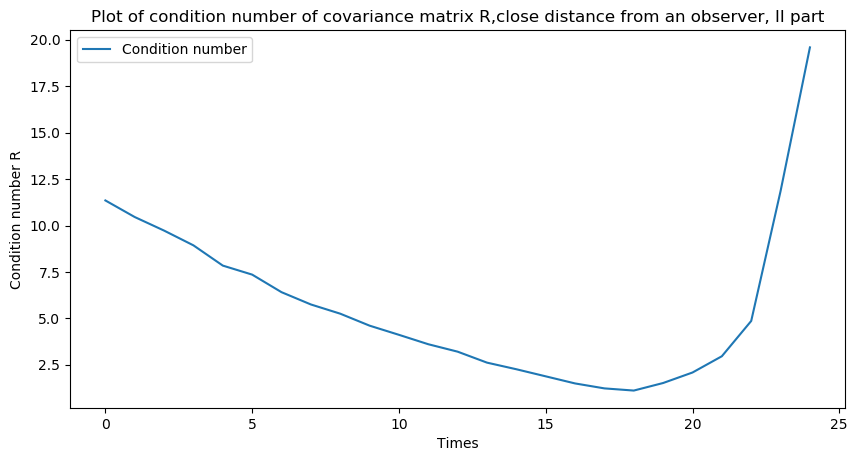

In [53]:
#Plot of condition number of covariance matrix R for x0,y0=3500/sqrt(2), sigma=20,0.02
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of condition number of covariance matrix R,close distance from an observer, II part')
plt.ylabel('Condition number R')
plt.xlabel('Times')
plt.plot(arrayRCondition14,label='Condition number')
plt.legend()
plt.show()  

In [38]:
#19
#Generate trajectory with x0,y0=3500/sqrt(2), sigma=50,0.0015
sigmasTrue19=[50,0.0015]
nyD19= np.random.normal(0, sigmasTrue19[0], 26)
nyB19= np.random.normal(0, sigmasTrue19[1], 26)
trajectoryCartesian19=MatrixX(26,2,x0=3500/(np.sqrt(2)),y0=3500/(np.sqrt(2)))
trajectoryPolar19=PolarTrajectory(trajectoryCartesian19)
z19=Measurements(trajectoryPolar19,nyD19,nyB19)

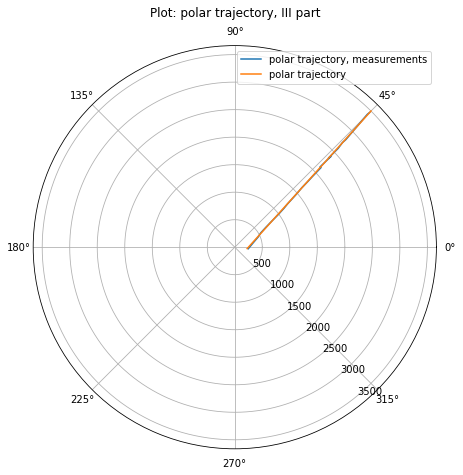

In [39]:
#Polar plot for x0,y0=3500/sqrt(2), sigma=50,0.0015
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
ax.plot(z19[1],z19[0],label='polar trajectory, measurements')
ax.plot(trajectoryPolar19[1],trajectoryPolar19[0],label='polar trajectory')
ax.set_title("Plot: polar trajectory, III part", va='bottom')
ax.set_rlabel_position(-50.5)
ax.legend()
plt.show()  

In [40]:
#Errors of extrapolation and filtration estimates for x0,y0=3500/sqrt(2), sigma=50,0.0015
def FinalError19(H,FI,runs,pFiltration,x00,sigmasTrue):
    error=0
    finalError=np.zeros((2,26))
    extropolationError=np.zeros((2,26))
    for i in range(runs):
        
        trajectoryCartesian=MatrixX(26,2,x0=3500/(np.sqrt(2)),y0=3500/(np.sqrt(2)))
        trajectoryPolar=PolarTrajectory(trajectoryCartesian)
        nyD= np.random.normal(0, sigmasTrue[0], 26)
        nyB= np.random.normal(0, sigmasTrue[1], 26)
        z=Measurements(trajectoryPolar,nyD,nyB)
        
        tracjectKalman, arrayXExtrapolation=Kalman(z,H,FI,0,pFiltration,x00,sigmasTrue)
                
        for j in range(trajectoryCartesian.shape[1]):
            distance=np.sqrt(tracjectKalman[0,j]**2+tracjectKalman[2,j]**2)
            azimuth=np.arctan(tracjectKalman[0,j]/tracjectKalman[2,j])
            finalError[0,j]+=(trajectoryPolar[0,j]-distance)**2
            finalError[1,j]+=(trajectoryPolar[1,j]-azimuth)**2 
            extropolationError[0,j]+=(trajectoryPolar[0,j]-arrayXExtrapolation[0,j])**2
            extropolationError[1,j]+=(trajectoryPolar[1,j]-arrayXExtrapolation[1,j])**2  
   
    finalError=np.sqrt(finalError/(runs-1))
    extropolationError=np.sqrt(extropolationError/(runs-1))
    return finalError, extropolationError

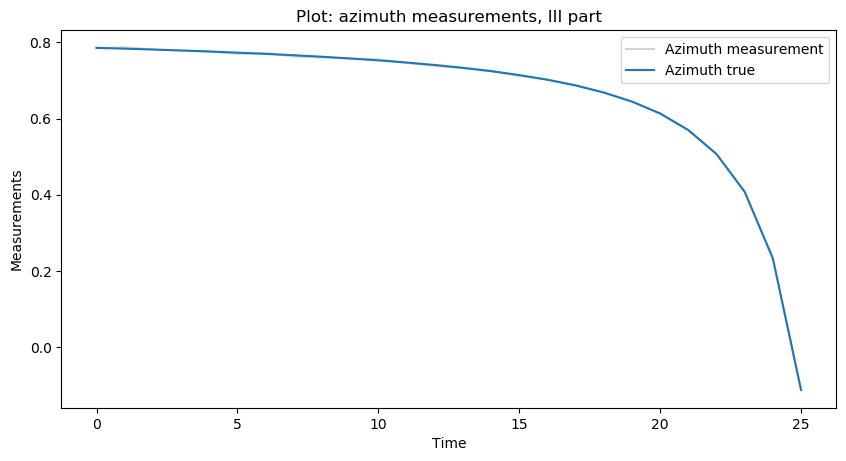

In [41]:
#Plot azimuth measurements for x0,y0=3500/sqrt(2), sigma=50,0.0015
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: azimuth measurements, III part')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z19[1],label='Azimuth measurement',color='lightgrey')
plt.plot(trajectoryPolar19[1],label='Azimuth true')
plt.legend()
plt.show()  

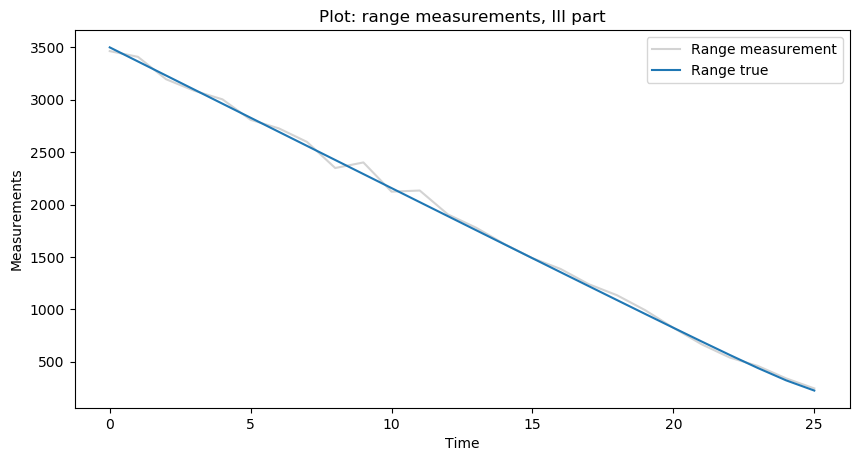

In [42]:
#Plot range measurements for x0,y0=3500/sqrt(2), sigma=50,0.0015
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: range measurements, III part')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(z19[0],label='Range measurement',color='lightgrey')
plt.plot(trajectoryPolar19[0],label='Range true')
plt.legend()
plt.show()  

In [43]:
#Calculating true errors of estimation for x0,y0=3500/sqrt(2), sigma=50,0.0015
finalError19,extropolationError19 =FinalError19(H,FI,500,p00,x00,sigmasTrue19)

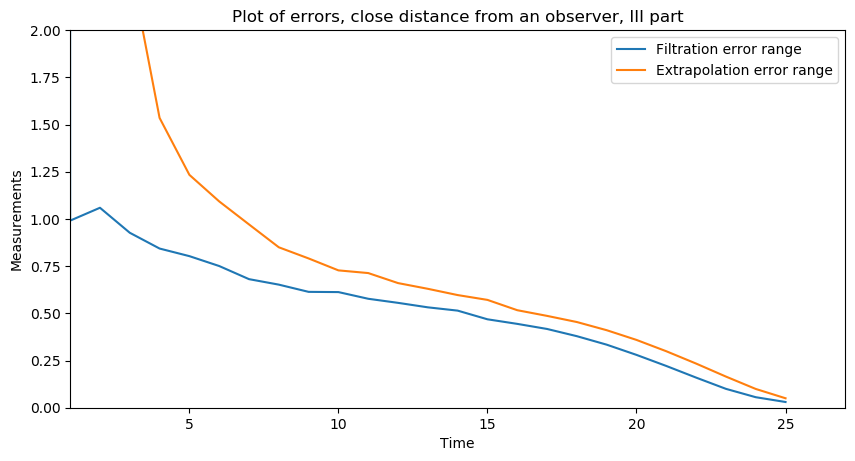

In [44]:
#Plot of relative errors range for x0,y0=3500/sqrt(2), sigma=50,0.0015
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of errors, close distance from an observer, III part')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(finalError19[0]/50,label='Filtration error range')
plt.plot(extropolationError19[0]/50,label='Extrapolation error range')
plt.xlim(1,27)
plt.ylim(0,2)
plt.legend()
plt.show()  

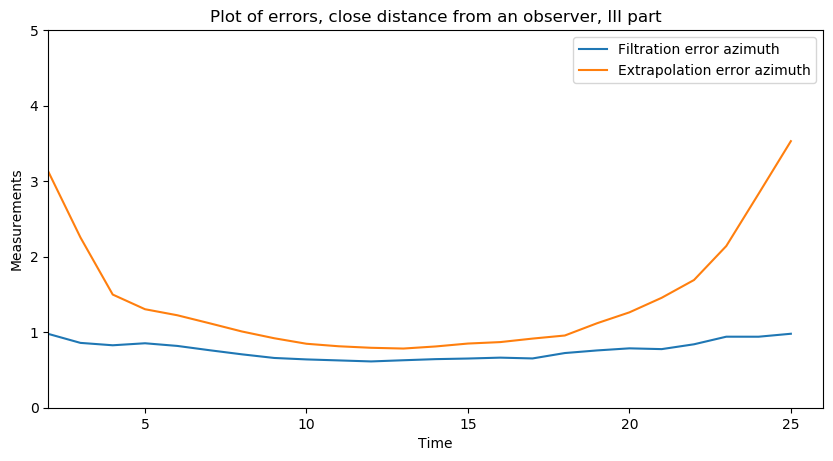

In [49]:
#Plot of relative errors range for x0,y0=3500/sqrt(2), sigma=50,0.0015
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of errors, close distance from an observer, III part')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(finalError19[1]/0.0015,label='Filtration error azimuth')
plt.plot(extropolationError19[1]/0.0015,label='Extrapolation error azimuth')
plt.xlim(2,26)
plt.ylim(0,5)
plt.legend()
plt.show()  

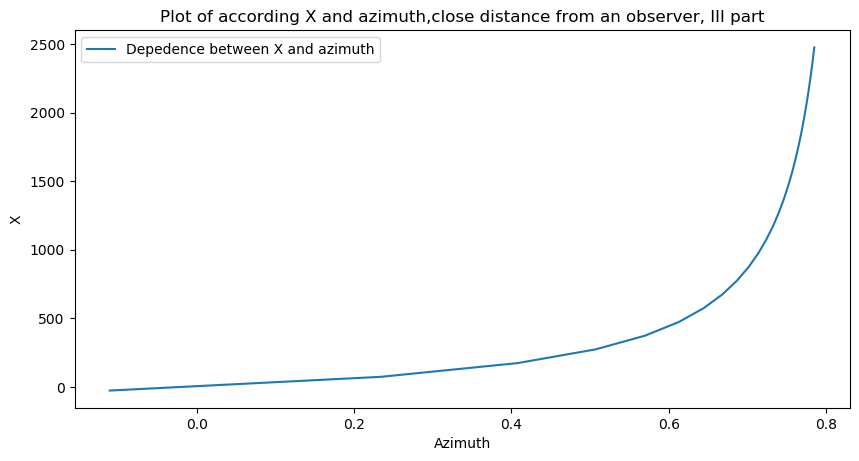

In [52]:
#Plot of dependence X and azimuth for x0,y0=3500/sqrt(2), sigma=50,0.0015
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of according X and azimuth,close distance from an observer, III part')
plt.ylabel('X')
plt.xlabel('Azimuth')
plt.plot(trajectoryPolar19[1],trajectoryCartesian19[0],label='Depedence between X and azimuth')
plt.legend()
plt.show()  

In [47]:
#Calculating condition number of covariance matrix R for x0,y0=3500/sqrt(2), sigma=50,0.0015
arrayRCondition19, arrayK19=KalmanConditionNumber(z19,H,FI,0,p00,x00,sigmasTrue19)

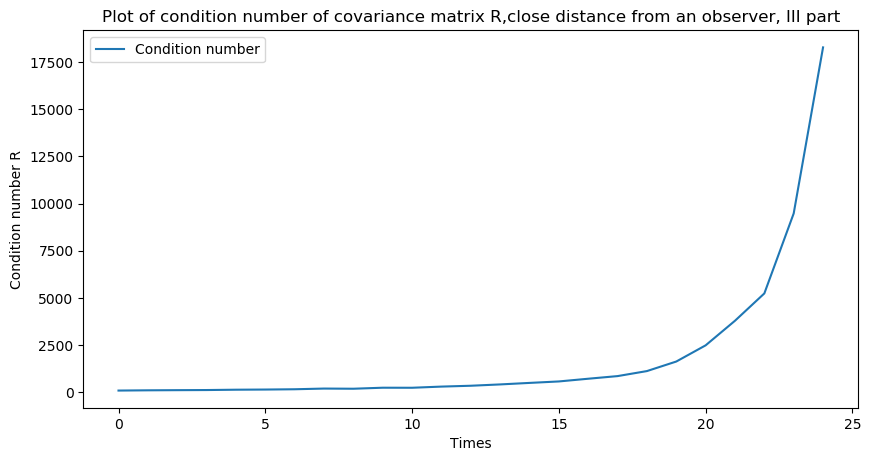

In [51]:
#Plot of condition number of covariance matrix R for x0,y0=3500/sqrt(2), sigma=50,0.0015
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot of condition number of covariance matrix R,close distance from an observer, III part')
plt.ylabel('Condition number R')
plt.xlabel('Times')
plt.plot(arrayRCondition19,label='Condition number')
plt.legend()
plt.show()  